# Machine Learning technique on PET block detector development - Part 2-3

## Crystal/Pixel discrimination for DQS PET block detector using Machine Learning techniques (v1.0, 2019-09)   
## (Continued from Part 2-2)
---


###  
### 7. Scintillator/Pixel discrimination using ML algorithms - Part III, using original multi-channel inputs
    Previous studies are focused on the comparison using ML algorithms similar ot the conventional decoding algorithms, which are using the pre-processed input as the ML algorithms' input variable. Such input variables usually had only two inputs, which is much smaller than the original input channels (36 input in the raw data).  
    In this section, we are repeat some of the algorithms been used in the previous sections with new input variables, the orginal inputs. Moreover, we will also try other algorithms with such inputs as well.

In [1]:
# load libraries

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# %matplotlib qt
%matplotlib inline
# %matplotlib notebook

import pickle
from sklearn.externals import joblib
from sklearn import metrics
import time

plt.rcParams['figure.dpi'] = 120 # default is 72

In [5]:
# re-load data

file = "D:\\ML on PET block\\new_concept_block_lso\\new_concept_block_15x15\\results\\ML_data\\new_concept_block_15x15_sorted_events1.csv"
df0 = pd.read_csv (file, comment='#')

X = df0.iloc[:,4:].values
decoding = df0.iloc[:,0:4].values

E_top = X[:,0:18]
E_bottom = X[:,18:36]

E_x1 = E_top[:, 0:18:2]
E_x2 = E_top[:, 18:0:-2]

E_y1 = E_bottom[:, 0:18:2]
E_y2 = E_bottom[:, 18:0:-2]

E_left = np.sum(E_x1, axis = 1)
E_right = np.sum(E_x2, axis = 1)

E_front = np.sum(E_y1, axis = 1)
E_back = np.sum(E_y2, axis = 1)


In [6]:
infile = open('./pickle/temp_data1','rb')
X_t, X_b, X_a, X_g, X_c, index_train, index_test = pickle.load(infile)
infile.close()


In [7]:
# pixel_xy = np.array(df0['index_y'] * 15 + df0['index_x'])
pixel_x = np.array(df0['index_x'])
pixel_y = np.array(df0['index_y'])
pixel_xy = pixel_y * 15 + pixel_x

pixel_x_train = pixel_x[index_train]
pixel_y_train = pixel_y[index_train]
pixel_xy_train = pixel_xy[index_train]

pixel_x_test = pixel_x[index_test]
pixel_y_test = pixel_y[index_test]
pixel_xy_test = pixel_xy[index_test]


In [5]:
from sklearn.utils import check_random_state

def random_cmap(ncolors=256, random_state=None):
    """
    Generate a matplotlib colormap consisting of random (muted) colors.

    A random colormap is very useful for plotting segmentation images.

    Parameters
    ----------
    ncolors : int, optional
        The number of colors in the colormap.  The default is 256.

    random_state : int or `~numpy.random.RandomState`, optional
        The pseudo-random number generator state used for random
        sampling.  Separate function calls with the same
        ``random_state`` will generate the same colormap.

    Returns
    -------
    cmap : `matplotlib.colors.Colormap`
        The matplotlib colormap with random colors.
    """

    from matplotlib import colors

    prng = check_random_state(random_state)
    h = prng.uniform(low=0.0, high=1.0, size=ncolors)
    s = prng.uniform(low=0.4, high=0.9, size=ncolors)
    v = prng.uniform(low=0.7, high=1.0, size=ncolors)
    hsv = np.dstack((h, s, v))
    rgb = np.squeeze(colors.hsv_to_rgb(hsv))

    return colors.ListedColormap(rgb)

In [6]:

def generate_grid(lut):
    """
    generate the grid of the lookup table from the lookup table data
    
    input: lookup table, numpy array
    output: grid as numpy array, the same size as the input 
    """
    
    lut_grid = np.zeros(lut.shape)
    pix_x, pix_y = lut_grid.shape

    for i in range(pix_x-1):
        for j in range(pix_y-1):
            if lut[i,j] != lut[i+1,j]:
                lut_grid[i,j] = 1
                lut_grid[i+1,j] = 1
            if lut[i,j] != lut[i,j+1]:
                lut_grid[i,j] = 1
                lut_grid[i,j+1] = 1
    
    return lut_grid

####  
#### 7.1 pixel discrimination using decision tree classification algorithms

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
def plot_prediction_boundary3(reg_func, cmap='hsv', alpha=1, axes=[0, 1.0, 0, 1.0], title='', ax=None):
    '''
    fitting the data with one function, the prediction is the unique pixel index
    '''
    if ax == None:
        fig, ax = plt.subplots(figsize=(4,4))
    
    x1s = np.linspace(axes[0], axes[1], 256)
    x2s = np.linspace(axes[2], axes[3], 256)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    pixel_xy_pred = reg_func.predict(X_new).reshape(x1.shape)

    lut_pred = pixel_xy_pred
    ax.imshow(lut_pred, alpha=alpha, cmap=cmap)
    ax.set_title(title)
        
        
    return lut_pred

In [9]:
def test_tree_classifier4(X, y, index_train, index_test, depth):
    '''
    output y is the unique pixel index pixel_xy
    '''

    X_train = X[index_train]
    X_test = X[index_test]
    y_train = y[index_train]
    y_test = y[index_test]
    

    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    tree_clf.fit(X_train, y_train)
    y_pred = tree_clf.predict(X_test)

    accuracy = sum(y_test==y_pred) / y_pred.size
    print('accuracy from tree classification (max_depth=%d): %f' % (depth,accuracy))

    return tree_clf, accuracy

accuracy from tree classification (max_depth=3): 0.031930
accuracy from tree classification (max_depth=5): 0.097685
accuracy from tree classification (max_depth=7): 0.222758
accuracy from tree classification (max_depth=9): 0.374902
accuracy from tree classification (max_depth=11): 0.505185
accuracy from tree classification (max_depth=13): 0.583720
accuracy from tree classification (max_depth=15): 0.629709
accuracy from tree classification (max_depth=17): 0.655389
accuracy from tree classification (max_depth=19): 0.665976
accuracy from tree classification (max_depth=21): 0.667570


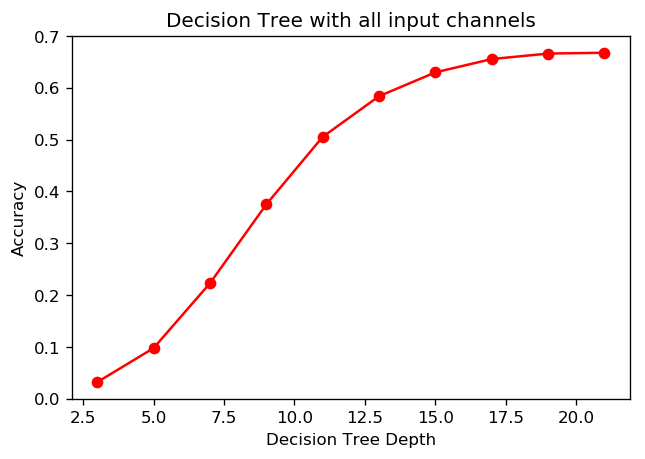

In [90]:
depth=[3,5,7,9,11,13,15,17,19,21]
#depth = [3,5]
accuracy = []

for index, n in enumerate(depth):
    clf, accu = test_tree_classifier4(X, pixel_xy, index_train, index_test, depth = n)
    accuracy.append(accu)
#    lut_pred = plot_prediction_boundary3(clf, cmap=random_cmap(), title='depth='+str(n), ax=ax[0,index])
#    ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')

#scale = 3
plt.plot(depth, accuracy,'ro-')
plt.title("Decision Tree with all input channels")
plt.xlabel("Decision Tree Depth")
plt.ylabel("Accuracy")
plt.savefig(".\\figs2\\decisiontree_accu_with_all_channels.png", dpi=300)

<b> saved output <b>
***
accuracy from tree classification (max_depth=3): 0.031930  
accuracy from tree classification (max_depth=5): 0.097685  
accuracy from tree classification (max_depth=7): 0.222758  
accuracy from tree classification (max_depth=9): 0.374902  
accuracy from tree classification (max_depth=11): 0.505185  
accuracy from tree classification (max_depth=13): 0.583720  
accuracy from tree classification (max_depth=15): 0.629709  
accuracy from tree classification (max_depth=17): 0.655389  
accuracy from tree classification (max_depth=19): 0.665976  
accuracy from tree classification (max_depth=21): 0.667570  

* <b>Decision Tree with all channel inputs achieved better result of 0.667 than that with pre-processed inputs (0.57).

####  
#### 7.2 pixel discrimination using Naive Bayes method
***


In [84]:
# Fitting Naive Bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB

def NB(X, y, index_train, index_test):
    '''
    output y is the unique pixel index pixel_xy
    '''

    X_train = X[index_train]
    X_test = X[index_test]
    y_train = y[index_train]
    y_test = y[index_test]
    
    accuracy = []
    clfs = []
    
    for nb in ['GaussianNB', 'BernoulliNB', 'MultinomialNB', 'ComplementNB']:
        clf = globals()[nb]()
        clf.fit(X_train, y_train)
        clfs.append(clf)
        
        y_pred = clf.predict(X_test)
        accu = sum(y_test==y_pred) / y_test.size
        accuracy.append(accu)
        print('Accuracy from %s: %f' % (nb,accu))
        
    return clfs, accu

In [85]:
clfs, accu = NB(X, pixel_xy, index_train, index_test)   
 

Accuracy from GaussianNB: 0.445725
Accuracy from BernoulliNB: 0.124037
Accuracy from MultinomialNB: 0.649577
Accuracy from ComplementNB: 0.146607


* <b>The Naive Bayes (Gassian) with all channel inputs result of 0.445 is not as good as that with preprocessed inputs of 0.507.</b>  
* <b>The Naive Bayes for multivariate Bernoulli models produces poor result.</b>
* <b>The Naive Bayes for multinomial models produces better result of 0.6496.</b>
* <b>The Naive Bayes (complement) produces poor result of 0.1466.</b>


####  
#### 7.3 pixel discrimination using KNN method
***

In [86]:
from sklearn.neighbors import KNeighborsClassifier


In [26]:
def KNN(X, y, index_train, index_test, neighbors=3):
    '''
    output y is the unique pixel index pixel_xy
    '''

    X_train = X[index_train]
    X_test = X[index_test]
    y_train = y[index_train]
    y_test = y[index_test]
    
    knn = KNeighborsClassifier(n_neighbors=neighbors, metric='minkowski', p=2, n_jobs=4)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = sum(y_test==y_pred) / y_test.size
    print("accuracy from KNN (neighbors=%d): %f" % (neighbors, accuracy))
        
    return knn, accuracy

In [67]:
# since KNN store all data set and need to calculate everything in predicting process, so it's slow for large data set with multiple variables
# therefore we limit the number of data set for training and testing
train_len = 500000
test_len = 1000

#neighbor_range  = [3,5,7,9,11]
neighbor_range  = [3]

for index, n in enumerate(neighbor_range):
    clf, accu = KNN(X, pixel_xy, index_train[:train_len], index_test[:test_len], neighbors = n)
#    lut_pred = plot_prediction_boundary3(clf, cmap=random_cmap(), title='neighbors='+str(n), ax=ax[0,index])
#    ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')


accuracy from KNN (neighbors=3): 0.763000


<b> saved output <b>
***
train_len = 100000, test_len = 10000  
>>
accuracy from KNN (neighbors=3): 0.699300  
accuracy from KNN (neighbors=5): 0.707300  
accuracy from KNN (neighbors=7): 0.703700  
accuracy from KNN (neighbors=8): 0.704600  
accuracy from KNN (neighbors=11): 0.702800  
  
train_len = 200000, test_len = 1000
>>
accuracy from KNN (neighbors=3): 0.742000  
accuracy from KNN (neighbors=5): 0.760000  
accuracy from KNN (neighbors=7): 0.762000  
accuracy from KNN (neighbors=8): 0.763000  
accuracy from KNN (neighbors=11): 0.759000  
    
train_len = 400000, test_len = 1000
>>
accuracy from KNN (neighbors=3): 0.767000  
accuracy from KNN (neighbors=5): 0.781000  
accuracy from KNN (neighbors=7): 0.783000  
accuracy from KNN (neighbors=8): 0.781000  
accuracy from KNN (neighbors=11): 0.781000   

train_len = 800000, test_len = 1000
>>
accuracy from KNN (neighbors=3): 0.769000  
accuracy from KNN (neighbors=5): 0.767000  
accuracy from KNN (neighbors=7): 0.782000  
accuracy from KNN (neighbors=9): 0.784000  
accuracy from KNN (neighbors=11): 0.782000      

In [24]:
import numpy as np

def KNN2(X, y, index_train, index_test, neighbors=3):
    '''
    output y is the unique pixel index pixel_xy
    '''

    X_train = X[index_train]
    X_test = X[index_test]
    y_train = y[index_train]
    y_test = y[index_test]
    
    accu = []
    
    if type(neighbors) == int:
        knn = KNeighborsClassifier(n_neighbors=n, metric='minkowski', p=2, n_jobs=4)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        accuracy = sum(y_test==y_pred) / y_test.size
        print("accuracy from KNN (neighbors=%d): %f" % (neighbors, accuracy))
        
        return knn, accuracy
        
    elif type(neighbors)==list or type(neighbors)==np.ndarray:

        for n in neighbors:
            knn = KNeighborsClassifier(n_neighbors=n, metric='minkowski', p=2, n_jobs=4)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)

            accuracy = sum(y_test==y_pred) / y_test.size
            print("accuracy from KNN (neighbors=%d): %f" % (n, accuracy))
            
            accu.append(accuracy)
        
        return knn, accu
    
    else:
        pass
    
    return 

accuracy from KNN (neighbors=3): 0.634000
accuracy from KNN (neighbors=5): 0.635000
accuracy from KNN (neighbors=7): 0.626000
accuracy from KNN (neighbors=9): 0.607000
accuracy from KNN (neighbors=11): 0.582000
accuracy from KNN (neighbors=3): 0.668000
accuracy from KNN (neighbors=5): 0.668000
accuracy from KNN (neighbors=7): 0.670000
accuracy from KNN (neighbors=9): 0.660000
accuracy from KNN (neighbors=11): 0.653000
accuracy from KNN (neighbors=3): 0.688000
accuracy from KNN (neighbors=5): 0.712000
accuracy from KNN (neighbors=7): 0.694000
accuracy from KNN (neighbors=9): 0.694000
accuracy from KNN (neighbors=11): 0.682000
accuracy from KNN (neighbors=3): 0.726000
accuracy from KNN (neighbors=5): 0.735000
accuracy from KNN (neighbors=7): 0.740000
accuracy from KNN (neighbors=9): 0.737000
accuracy from KNN (neighbors=11): 0.725000
accuracy from KNN (neighbors=3): 0.742000
accuracy from KNN (neighbors=5): 0.760000
accuracy from KNN (neighbors=7): 0.762000
accuracy from KNN (neighbors=9

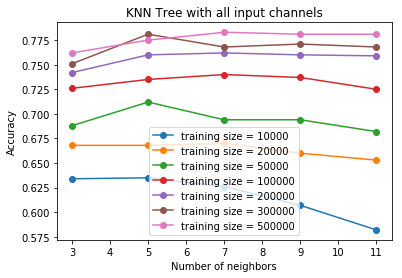

In [29]:
train_len = [10000, 20000, 50000, 100000, 200000, 300000, 500000]
test_len = 1000
accuracy = []
neighbors = [x for x in range(3,13,2)]

for L in train_len:
    clf, accu = KNN2(X, pixel_xy, index_train[:L], index_test[:test_len], neighbors = neighbors)
    accuracy.append(accu)
#    lut_pred = plot_prediction_boundary3(clf, cmap=random_cmap(), title='depth='+str(n), ax=ax[0,index])
#    ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')

lines = []
for j in range(len(accuracy)):
    line, = plt.plot(neighbors, accuracy[j],'o-', label='training size = '+ str(train_len[j]))
    lines.append(line)
    
plt.title("KNN Tree with all input channels")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig(".\\figs2\\KNN_accu_with_all_channels.png", dpi=300)

* <b>The KNN with all channel inputs could achieve over 0.70 with 100k events or 0.78 with 500k events which is much better than that with preprocessed inputs which is around 0.56.</b>  


####  
#### 7.4 pixel discrimination using SVM method
***
The previous studies are using the Anger decoding or Light Channel decoding techniques, in which the input variables are the combinations of original input variables (photosensor counts). Here we will use the SVM algorithm along with the original input variables to see whether better prediction could be made from the original variables.  
<b>Since one of the SVM's advantage is that it works more effectively on high dimensional spaces, which means more input variables, it works better. With the Anger decoding or Light Channel decoding techniques, the 36 input variables are reduced to only two variables. which might not be suitable for SVM algorithm. 

In [8]:
from sklearn.svm import SVC

#####  
##### 7.4.1 SVM using original 36 sensors input variables
* Based on the study results from [svm_test2](https://github.com/yzhang3000/Machine-Learning-Techniques-on-PET-block-detector-development/blob/master/python/svm_test2.md) memtioned above, we are choosing 'poly' as the kernel and data set length is 10k to 50k.

In [2]:
# load the model generated by svm_test2

import pickle

svm_model_file ='.//models//svm_poly_50k.pkl'
fp = open(svm_model_file,'rb')
data = pickle.load(fp)
fp.close()

In [10]:
data

[[10000, 20000, 30000, 40000, 50000],
 [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=1, shrinking=True,
    tol=0.001, verbose=False),
  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=1, shrinking=True,
    tol=0.001, verbose=False),
  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=1, shrinking=True,
    tol=0.001, verbose=False),
  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=1, shrinking=True,
    tol=0.001, verbose=False),
  SVC(C=1.0, cache_size=200, class

* The variable **data** contains a list of SVC classifiers which are trained with the data set of 10k, 20k, 30k, 40k, 50k events, respectively.

In [3]:
model = data[1][4]

In [9]:
# test accuracy

testing_data_length = 1000

X_test = X[index_test[:testing_data_length]]
pixel_xy_pred = model.predict(X_test)
accuracy = sum(pixel_xy_test[:testing_data_length]==pixel_xy_pred) / testing_data_length
print('accuracy score: %f' % (metrics.accuracy_score(pixel_xy_test[:testing_data_length], pixel_xy_pred)))
 

accuracy score: 0.709000


In [15]:
accuracy = []
test_lens= [100,500,1000,2000,4000]

for test_len in test_lens:
    accu = []
    for train_len, clf in zip(data[0], data[1]):
        y_pred = clf.predict(X[index_test[:test_len]])
        accu.append( sum(y_pred==pixel_xy_test[:test_len]) / test_len)
    accuracy.append(accu)
        

In [16]:
accuracy

[[0.64, 0.63, 0.65, 0.61, 0.67],
 [0.628, 0.658, 0.668, 0.672, 0.698],
 [0.63, 0.676, 0.689, 0.687, 0.709],
 [0.6405, 0.6655, 0.6785, 0.68, 0.691],
 [0.63, 0.66, 0.672, 0.68225, 0.6915]]

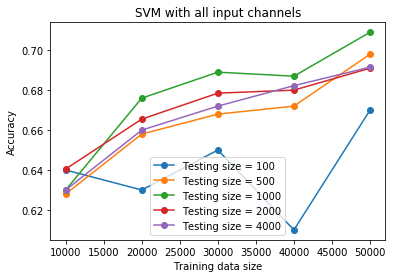

In [22]:
lines = []
for j in range(len(accuracy)):
    line, = plt.plot(data[0], accuracy[j],'o-', label='Testing size = '+ str(test_lens[j]))
    lines.append(line)
    
plt.title("SVM with all input channels")
plt.xlabel("Training data size")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig(".\\figs2\\SVM_accu_with_all_channels.png", dpi=300)

###  
### Conclusion - accuracy using all channel data as input
***
* Decision Tree: 0.667570 (max_depth=21) 
* Naive Bayes (GaussianNB): 0.445725  
* Naive Bayes (BernoulliNB): 0.124037  
* Naive Bayes (MultinomialNB): 0.649577  
* Naive Bayes (ComplementNB): 0.146607  
* KNN: 0.783 (500k training, 7 neighbors)
* SVM: 0.691 (50k training, 4000 testing)